## Build KNN Class

In [ ]:
# TODO: Buat class KNN yang akan Anda gunakan untuk classification dan regression
import numpy as np
from scipy import stats
from sklearn.metrics import precision_score, \
    recall_score, classification_report, \
    accuracy_score, f1_score
from typing import Literal
import pandas as pd
import seaborn as sns
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split, KFold
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

class KNN:
    def __init__(self, k, metric, task):
        self.k = k
        self.metric = metric
        self.task = task

    def euclidean(self, x, y):
        """
          Calculates the Euclidean distance between two data points.

          Args:
          x (list): first data points
          y (list): second data points

          Returns:
          - Data Type: float
          - Euclidean distance between the two data points.
        """
        assert len(x) == len(y) # Memastikkan panjang row yang dibandingkan sama.

        return np.sqrt(np.sum((x-y)**2))

    def manhattan(self, x, y):
        """
          Calculates the Manhattan distance between two data points.

          Args:
          x (list): first data points
          y (list): second data points

          Returns:
          - Data Type: float
          - Manhattan distance between the two data points.
        """
        assert len(x) == len(y) # Memastikkan panjang row yang dibandingkan sama.

        return np.sum(np.abs(x-y))

    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train

    def predict(self, X_test):
        predictions = []
        if self.task == "classification":
            for ind in X_test:
              neighbours = self.get_neighbours(ind)
              majority = stats.mode(neighbours)[0]
              predictions.append(majority)
        elif self.task == "regression":
            for ind in X_test:
              neighbours = self.get_neighbours(ind)
              avg = np.mean(neighbours)
              predictions.append(avg)

        return np.array(predictions)

    def get_neighbours(self, test_ind):
        distances = []
        if self.metric=='euclidean':
            for (ind, dep) in zip(self.X_train, self.y_train):
              distance = self.euclidean(ind, test_ind)
              distances.append((dep, distance))
        elif self.metric=='manhattan':
            for (ind, dep) in zip(self.X_train, self.y_train):
              distance = self.manhattan(ind, test_ind)
              distances.append((dep, distance))
        else :
            raise NameError('Jarak harus berupa euclidean atau manhattan')
        neighbours = sorted(distances, key=lambda x: x[1])

        return [neighbour[0] for neighbour in neighbours[:self.k]]

# Classification

In [ ]:
# TODO: Gunakan class KNN yang Anda buat untuk menentukan class dari kerang Abalone
import seaborn as sns

clf = KNN(k = 5, metric = "euclidean", task = "classification")

### Preprocessing

Banyaknya baris pada dataset:  4177
Banyaknya kolom pada dataset:  8
Ada 7 data numerikal
Ada 1 data kategorikal
Column Numerical:  ['Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight', 'Viscera weight', 'Shell weight']
Column Categorical:  ['Class']


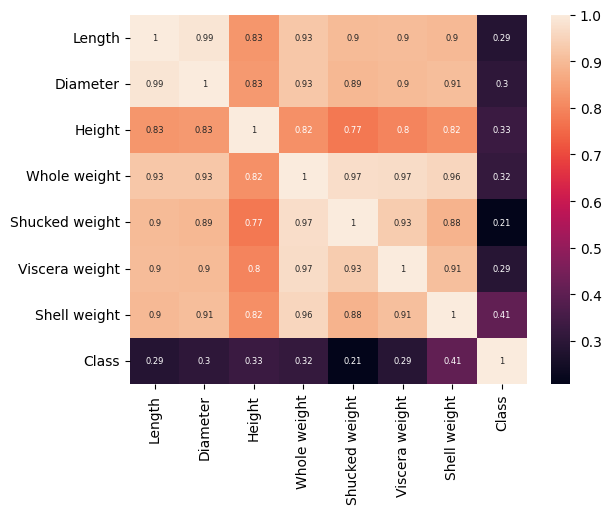

In [ ]:
# TODO: Lakukan preprocessing

df_clf = pd.read_csv("dataset.csv")

correlation_matrix = df_clf.corr(method='pearson')

sns.heatmap(correlation_matrix, annot= True, annot_kws={"fontsize":6})

rows, columns = df_clf.shape
print("Banyaknya baris pada dataset: ", rows)
print("Banyaknya kolom pada dataset: ", columns)

df_clf_numerical = df_clf.select_dtypes(include=['float64'])
df_clf_categorical = df_clf.select_dtypes(exclude=['float64'])

print('Ada', df_clf_numerical.shape[1], 'data numerikal')
print('Ada', df_clf_categorical.shape[1], 'data kategorikal')

col_clf_numerical = list(df_clf_numerical.columns)
col_clf_categorical = list(df_clf_categorical.columns)

print("Column Numerical: ", col_clf_numerical)
print("Column Categorical: ", col_clf_categorical)

In [ ]:
def check_null(df):
    col_na = df.isnull().sum().sort_values(ascending=True)
    percent = col_na / len(df)
    missing_data = pd.concat([col_na, percent], axis=1, keys=['Total', 'Percent'])

    if (missing_data[missing_data['Total'] > 0].shape[0] == 0):
        print("Tidak ditemukan missing value pada dataset")
    else:
        print(missing_data[missing_data['Total'] > 0])

def check_outlier(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)

    # Menghitung RUB dan RLB.
    IQR = Q3 - Q1
    lower_limit = Q1 - 1.5*IQR
    upper_limit = Q3 + 1.5*IQR

    # Menampilkan banyaknya outlier pada atribut.
    outliers = (df < lower_limit) | (df > upper_limit)
    print ("Outlier pada tiap atribut:")
    print(outliers.sum())

    return outliers

def determine_outlier_thresholds_iqr(dataframe, col_name, th1=0.25, th3=0.75):
    quartile1 = dataframe[col_name].quantile(th1)
    quartile3 = dataframe[col_name].quantile(th3)
    iqr = quartile3 - quartile1
    upper_limit = quartile3 + 1.5 * iqr
    lower_limit = quartile1 - 1.5 * iqr
    return lower_limit, upper_limit

def check_outliers_iqr(dataframe, col_name):
    lower_limit, upper_limit = determine_outlier_thresholds_iqr(dataframe, col_name)
    if dataframe[(dataframe[col_name] > upper_limit) | (dataframe[col_name] < lower_limit)].any(axis=None):
        return True
    else:
        return False

def replace_with_thresholds_iqr(dataframe, cols, target_value, col_categorical = [], replace=False):
    from tabulate import tabulate
    data = []
    for col_name in cols:
        if col_name != target_value and (col_name not in col_categorical):
            outliers_ = check_outliers_iqr(dataframe,col_name)
            count = None
            lower_limit, upper_limit = determine_outlier_thresholds_iqr(dataframe, col_name)
            if outliers_:
                count = dataframe[(dataframe[col_name] > upper_limit) | (dataframe[col_name] < lower_limit)][col_name].count()
                if replace:
                    if lower_limit < 0:
                        dataframe.loc[(dataframe[col_name] > upper_limit), col_name] = upper_limit
                    else:
                        dataframe.loc[(dataframe[col_name] < lower_limit), col_name] = lower_limit
                        dataframe.loc[(dataframe[col_name] > upper_limit), col_name] = upper_limit
            outliers_status = check_outliers_iqr(dataframe, col_name)
            data.append([outliers_, outliers_status, count, col_name, lower_limit, upper_limit ])
    table = tabulate(data, headers=['Outliers (Previously)', 'Outliers', 'Count', 'Column', 'Lower Limit', 'Upper Limit'], tablefmt='rst', numalign='right')
    print("Removing Outliers using IQR")
    print(table)


def determine_outlier_thresholds_std(dataframe, col_name):
    upper_boundary = dataframe[col_name].mean() + 3 * dataframe[col_name].std()
    lower_boundary = dataframe[col_name].mean() - 3 * dataframe[col_name].std()
    return lower_boundary, upper_boundary

def check_outliers_std(dataframe, col_name):
    lower_boundary, upper_boundary = determine_outlier_thresholds_std(dataframe, col_name)
    if dataframe[(dataframe[col_name] > upper_boundary) | (dataframe[col_name] < lower_boundary)].any(axis=None):
        return True
    else:
        return False

def replace_with_thresholds_std(dataframe, cols, target_value, col_categorical = [], replace=False):
    from tabulate import tabulate
    data = []
    for col_name in cols:
        if col_name != target_value and col_name not in col_categorical:
            outliers_ = check_outliers_std(dataframe, col_name)
            count = None
            lower_limit, upper_limit = determine_outlier_thresholds_std(dataframe, col_name)
            if outliers_:
                count = dataframe[(dataframe[col_name] > upper_limit) | (dataframe[col_name] < lower_limit)][col_name].count()
                if replace:
                    if lower_limit < 0:
                        dataframe.loc[(dataframe[col_name] > upper_limit), col_name] = upper_limit
                    else:
                        dataframe.loc[(dataframe[col_name] < lower_limit), col_name] = lower_limit
                        dataframe.loc[(dataframe[col_name] > upper_limit), col_name] = upper_limit
            outliers_status = check_outliers_std(dataframe, col_name)
            data.append([outliers_, outliers_status,count, col_name, lower_limit, upper_limit])
    table = tabulate(data, headers=['Outlier (Previously)','Outliers','Count', 'Column','Lower Limit', 'Upper Limit'], tablefmt='rst', numalign='right')
    print("Removing Outliers using 3 Standard Deviation")
    print(table)

def remove_outlier(df, outlier_type: Literal['iqr', 'std', "nah"], target_value, col_categorical):
  print(dict(check_outlier(df).sum()))
  print("Boxplot Old")
  df.boxplot(vert=False, figsize=(20,20))
  if(outlier_type == "iqr"):
    replace_with_thresholds_iqr(df, df.columns, target_value, col_categorical, replace=True)
  elif(outlier_type == "std"):
    replace_with_thresholds_std(df, df.columns, target_value, col_categorical, replace = True)
  else:
    pass

def preprocess(df, outlier_type, target_value, col_categorical):
  check_null(df)

  print("Duplicates value on dataset:", df.duplicated().sum())

  # df.drop_duplicates(inplace=True)

  # print("Duplicates value on dataset:", df.duplicated().sum()) # 0 now

  remove_outlier(df, outlier_type, target_value, col_categorical)

Tidak ditemukan missing value pada dataset
Duplicates value on dataset: 0
Outlier pada tiap atribut:
Length             49
Diameter           59
Height             29
Whole weight       30
Shucked weight     48
Viscera weight     26
Shell weight       35
Class             960
dtype: int64
{'Length': 49, 'Diameter': 59, 'Height': 29, 'Whole weight': 30, 'Shucked weight': 48, 'Viscera weight': 26, 'Shell weight': 35, 'Class': 960}
Boxplot Old


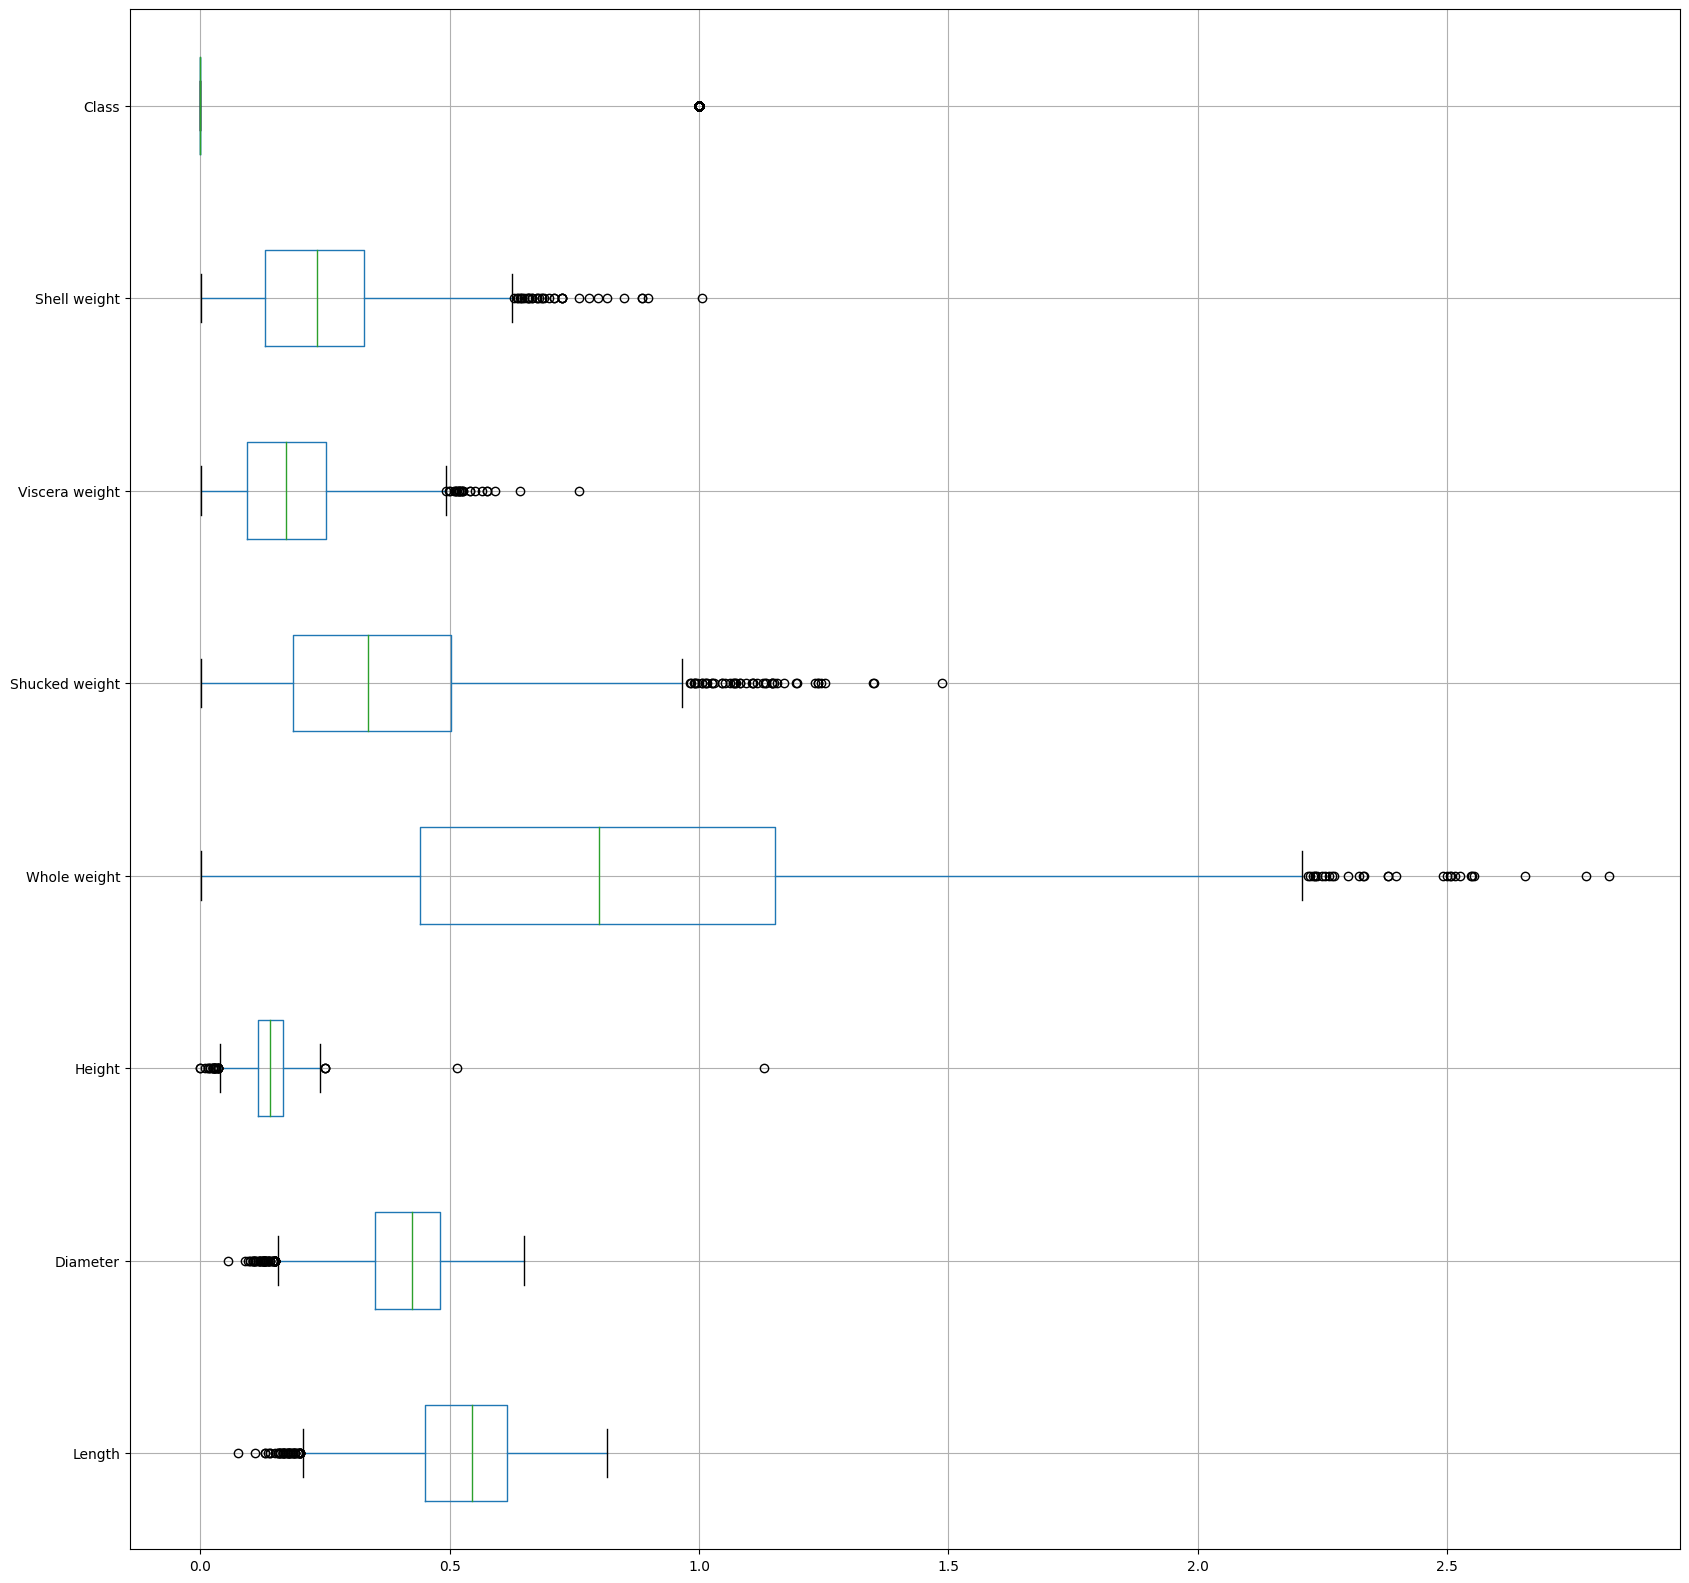

In [ ]:
preprocess(df_clf, "nah", "Class", col_clf_categorical)

New Boxplot


<Axes: >

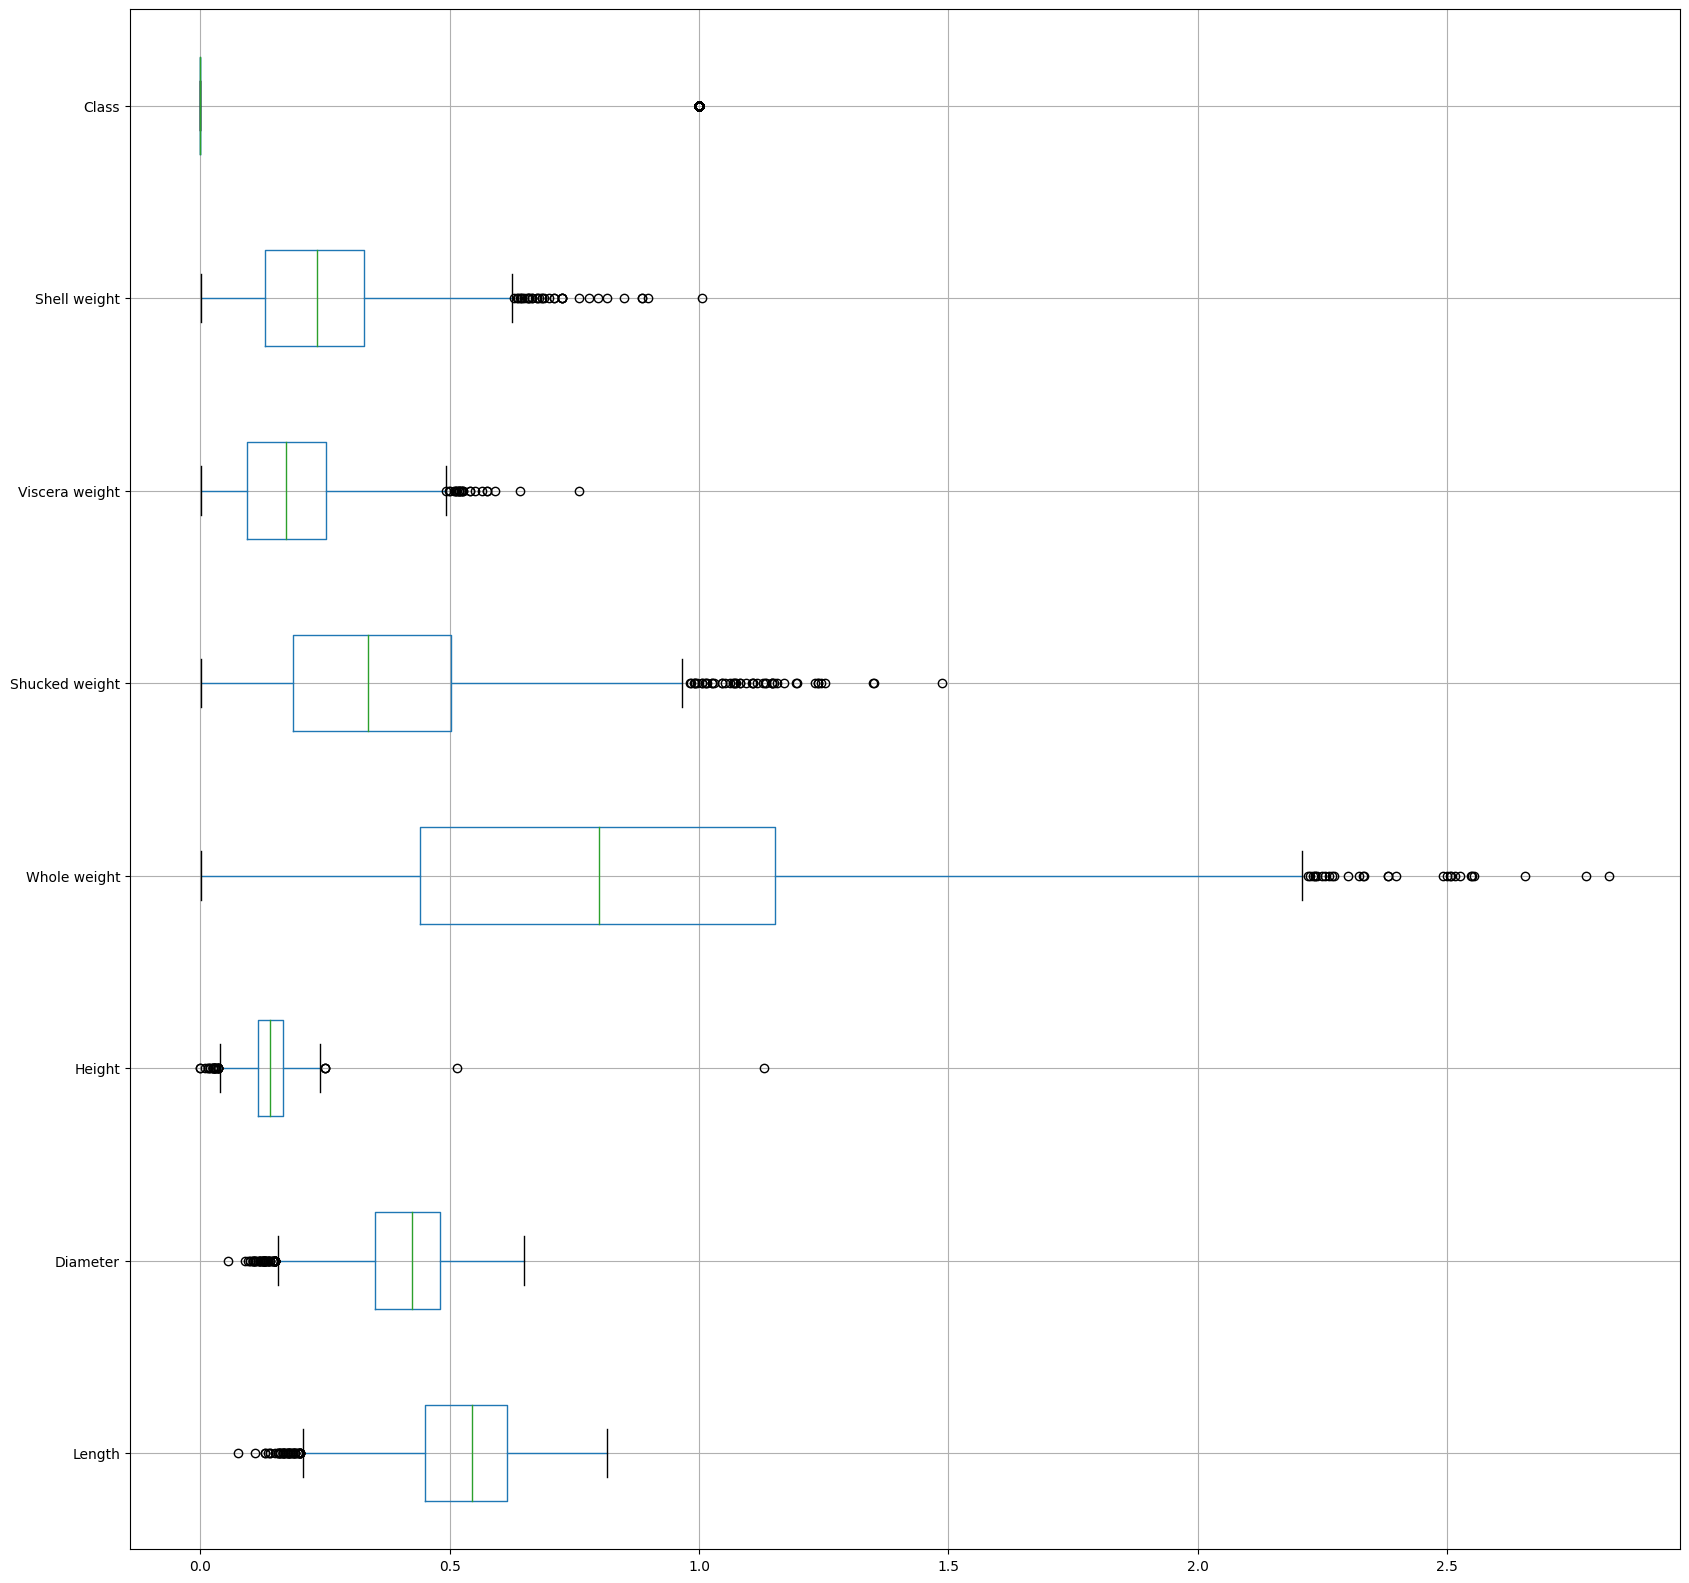

In [ ]:
# Boxplot after removing outlier

print("New Boxplot")
df_clf.boxplot(vert=False, figsize=(20,20))

### Feature selection dan split data

In [ ]:
# TODO: Lakukan pemilihan atribut dan split data menjadi train dan test

X_clf = df_clf.drop(['Class', 'Viscera weight'], axis = 1)
y_clf = df_clf['Class']

X_clf_train, X_clf_test, y_clf_train, y_clf_test = train_test_split(X_clf, y_clf, test_size = 0.2, stratify=y_clf, random_state = 2)

X_clf_train = pd.DataFrame(X_clf_train, columns=X_clf.columns)
X_clf_test = pd.DataFrame(X_clf_test, columns=X_clf.columns)
y_clf_train = pd.Series(y_clf_train, name="Class")

def scale_train_and_test(X_train, X_test, numerical_column):
    """ Ini adalah approach yang dilakukan berdasarkan hint diatas (Standarisasi dilatih terlebihi dahulu pada data training),
      lalu berdasarkan hasilnya standarisasi data training dan testnya.
      Note: tidak dilakukan standarisasi terhadap kolom yang sebelumnya kategorikal
    """
    scaler = MinMaxScaler()

    scaler.fit(X_train[numerical_column])

    X_train_scaled = X_train.copy()
    X_train_scaled[numerical_column] = scaler.transform(X_train[numerical_column])

    X_test_scaled = X_test.copy()
    X_test_scaled[numerical_column] = scaler.transform(X_test[numerical_column])

    return X_train_scaled, X_test_scaled, scaler

col_clf_numerical.remove("Viscera weight")
X_clf_train_scaled, X_clf_test_scaled, temp_scaler = scale_train_and_test(X_clf_train, X_clf_test, col_clf_numerical)
X_clf_train_scaled

,Length,Diameter,Height,Whole weight,Shucked weight,Shell weight
3802,0.310811,0.294118,0.066372,0.050823,0.043333,0.048331
1799,0.709459,0.689076,0.146018,0.366920,0.367778,0.248630
840,0.560811,0.554622,0.110619,0.214981,0.226296,0.175386
2034,0.743243,0.773109,0.159292,0.476890,0.388519,0.389636
1021,0.763514,0.756303,0.137168,0.496016,0.521481,0.332337
...,...,...,...,...,...,...
3021,0.513514,0.504202,0.092920,0.131043,0.101481,0.133034
755,0.736486,0.756303,0.163717,0.540287,0.510370,0.347285
1095,0.540541,0.495798,0.097345,0.160970,0.151852,0.128052
2341,0.317568,0.310924,0.079646,0.050823,0.044074,0.043348


### Train dan test model

In [ ]:
def evaluate_classifier_performance(prediction, y_test):
    # Informasi evaluasi secara compact
    print("Hasil Evaluasi berdasarkan classification report \n\n%s\n" % (classification_report(y_test, prediction,zero_division=0)))
    print()
    print("Confusion Matrix")
    print()
    y_actual = pd.Series(np.array(y_test), name = "actual")
    y_pred = pd.Series(np.array(prediction), name = "prediction")
    df_confusion = pd.crosstab(y_actual, y_pred)
    display(df_confusion)
    print()
    print()

    print("Butuh informasi lebih lengkap? silakan simak di bawah ini : ")
    print('Accuracy Average:', accuracy_score(y_test, prediction))
    print('F1 Macro Average:', f1_score(y_test, prediction, average='macro'))
    print('F1 Micro Average:', f1_score(y_test, prediction, average='micro'))
    print('Precision Macro Average:', precision_score(y_test, prediction, average='macro',zero_division=0))
    print('Precision Micro Average:', precision_score(y_test, prediction, average='micro',zero_division=0))
    print('Recall Macro Average:', recall_score(y_test, prediction, average='macro',zero_division=0))
    print('Recall Micro Average:', recall_score(y_test, prediction, average='micro',zero_division=0))
    print()

In [ ]:
# TODO: Lakukan training dan testing pada model KNN
clf.fit(X_clf_train.values, y_clf_train.values)
prediction = clf.predict(X_clf_test.values)

evaluate_classifier_performance(prediction, y_clf_test.values)

Hasil Evaluasi berdasarkan classification report 

              precision    recall  f1-score   support

           0       0.86      0.92      0.89       644
           1       0.64      0.48      0.55       192

    accuracy                           0.82       836
   macro avg       0.75      0.70      0.72       836
weighted avg       0.81      0.82      0.81       836



Confusion Matrix



prediction,0,1
actual,,
0,592,52
1,100,92




Butuh informasi lebih lengkap? silakan simak di bawah ini : 
Accuracy Average: 0.8181818181818182
F1 Macro Average: 0.7169232962646136
F1 Micro Average: 0.8181818181818182
Precision Macro Average: 0.7471901091843288
Precision Micro Average: 0.8181818181818182
Recall Macro Average: 0.6992106625258799
Recall Micro Average: 0.8181818181818182



### Hyperparameter tuning

In [ ]:
# TODO: Lakukan hyperparameter tuning pada model KNN
k_values = [3, 5, 7, 9, 11, 15, 21, 31, 41, 51, 63]

evaluations = []

for k in k_values:
  for metric in ["euclidean", "manhattan"]:
    clf = KNN(k = k, metric = metric, task = "classification")
    clf.fit(X_clf_train.values, y_clf_train.values)
    prediction = clf.predict(X_clf_test.values)

    f1 = f1_score(y_clf_test.values, prediction)
    print(f'k={k} and metric = {metric.upper()}, F1 Score={f1}')

    evaluations.append(f1)

k=3 and metric = EUCLIDEAN, F1 Score=0.5325443786982248
k=3 and metric = MANHATTAN, F1 Score=0.5028571428571429
k=5 and metric = EUCLIDEAN, F1 Score=0.5476190476190476
k=5 and metric = MANHATTAN, F1 Score=0.5194029850746269
k=7 and metric = EUCLIDEAN, F1 Score=0.5382262996941897
k=7 and metric = MANHATTAN, F1 Score=0.5149700598802396
k=9 and metric = EUCLIDEAN, F1 Score=0.5240963855421686
k=9 and metric = MANHATTAN, F1 Score=0.5107692307692309
k=11 and metric = EUCLIDEAN, F1 Score=0.50625
k=11 and metric = MANHATTAN, F1 Score=0.5110410094637224
k=15 and metric = EUCLIDEAN, F1 Score=0.5246913580246914
k=15 and metric = MANHATTAN, F1 Score=0.5125
k=21 and metric = EUCLIDEAN, F1 Score=0.5175718849840255
k=21 and metric = MANHATTAN, F1 Score=0.503225806451613
k=31 and metric = EUCLIDEAN, F1 Score=0.525974025974026
k=31 and metric = MANHATTAN, F1 Score=0.509933774834437
k=41 and metric = EUCLIDEAN, F1 Score=0.5148514851485149
k=41 and metric = MANHATTAN, F1 Score=0.5131578947368421
k=51 and

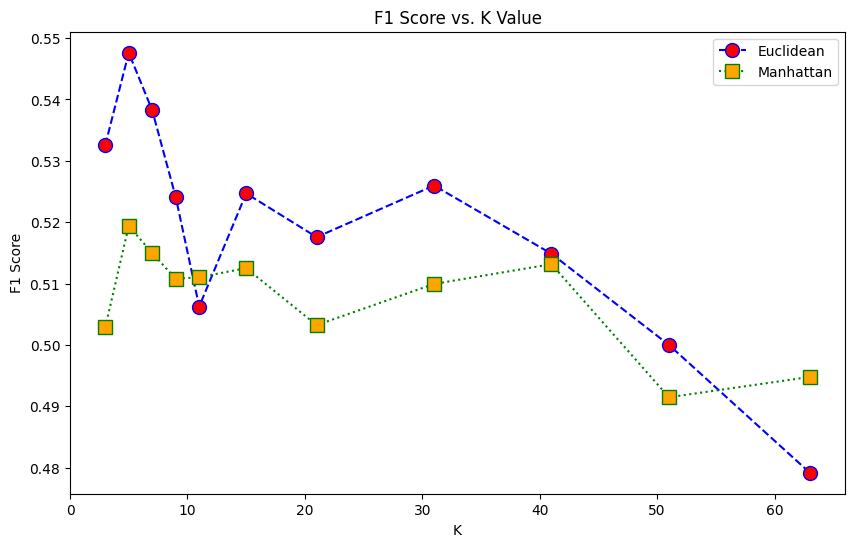

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(k_values, [(evaluations[i]) for i in range(0, len(evaluations), 2)] ,color='blue', linestyle='dashed',
         marker='o', markerfacecolor='red', markersize=10, label='Euclidean')

plt.plot(k_values, [(evaluations[i]) for i in range(1, len(evaluations), 2)], color='green', linestyle='dotted',
         marker='s', markerfacecolor='orange', markersize=10, label='Manhattan')

plt.title('F1 Score vs. K Value')
plt.xlabel('K')
plt.ylabel('F1 Score')
plt.legend()
plt.show()

# Regression

In [ ]:
# TODO: Gunakan class KNN yang Anda buat untuk menentukan Whole weight dari kerang Abalone

reg = KNN(k = 5, metric = "euclidean", task = "regression")

### Preprocessing

Ada 7 data numerikal
Ada 1 data kategorikal
Column Numerical:  ['Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight', 'Viscera weight', 'Shell weight']
Column Categorical:  ['Class']
Tidak ditemukan missing value pada dataset
Duplicates value on dataset: 0
Outlier pada tiap atribut:
Length             49
Diameter           59
Height             29
Whole weight       30
Shucked weight     48
Viscera weight     26
Shell weight       35
Class             960
dtype: int64
{'Length': 49, 'Diameter': 59, 'Height': 29, 'Whole weight': 30, 'Shucked weight': 48, 'Viscera weight': 26, 'Shell weight': 35, 'Class': 960}
Boxplot Old


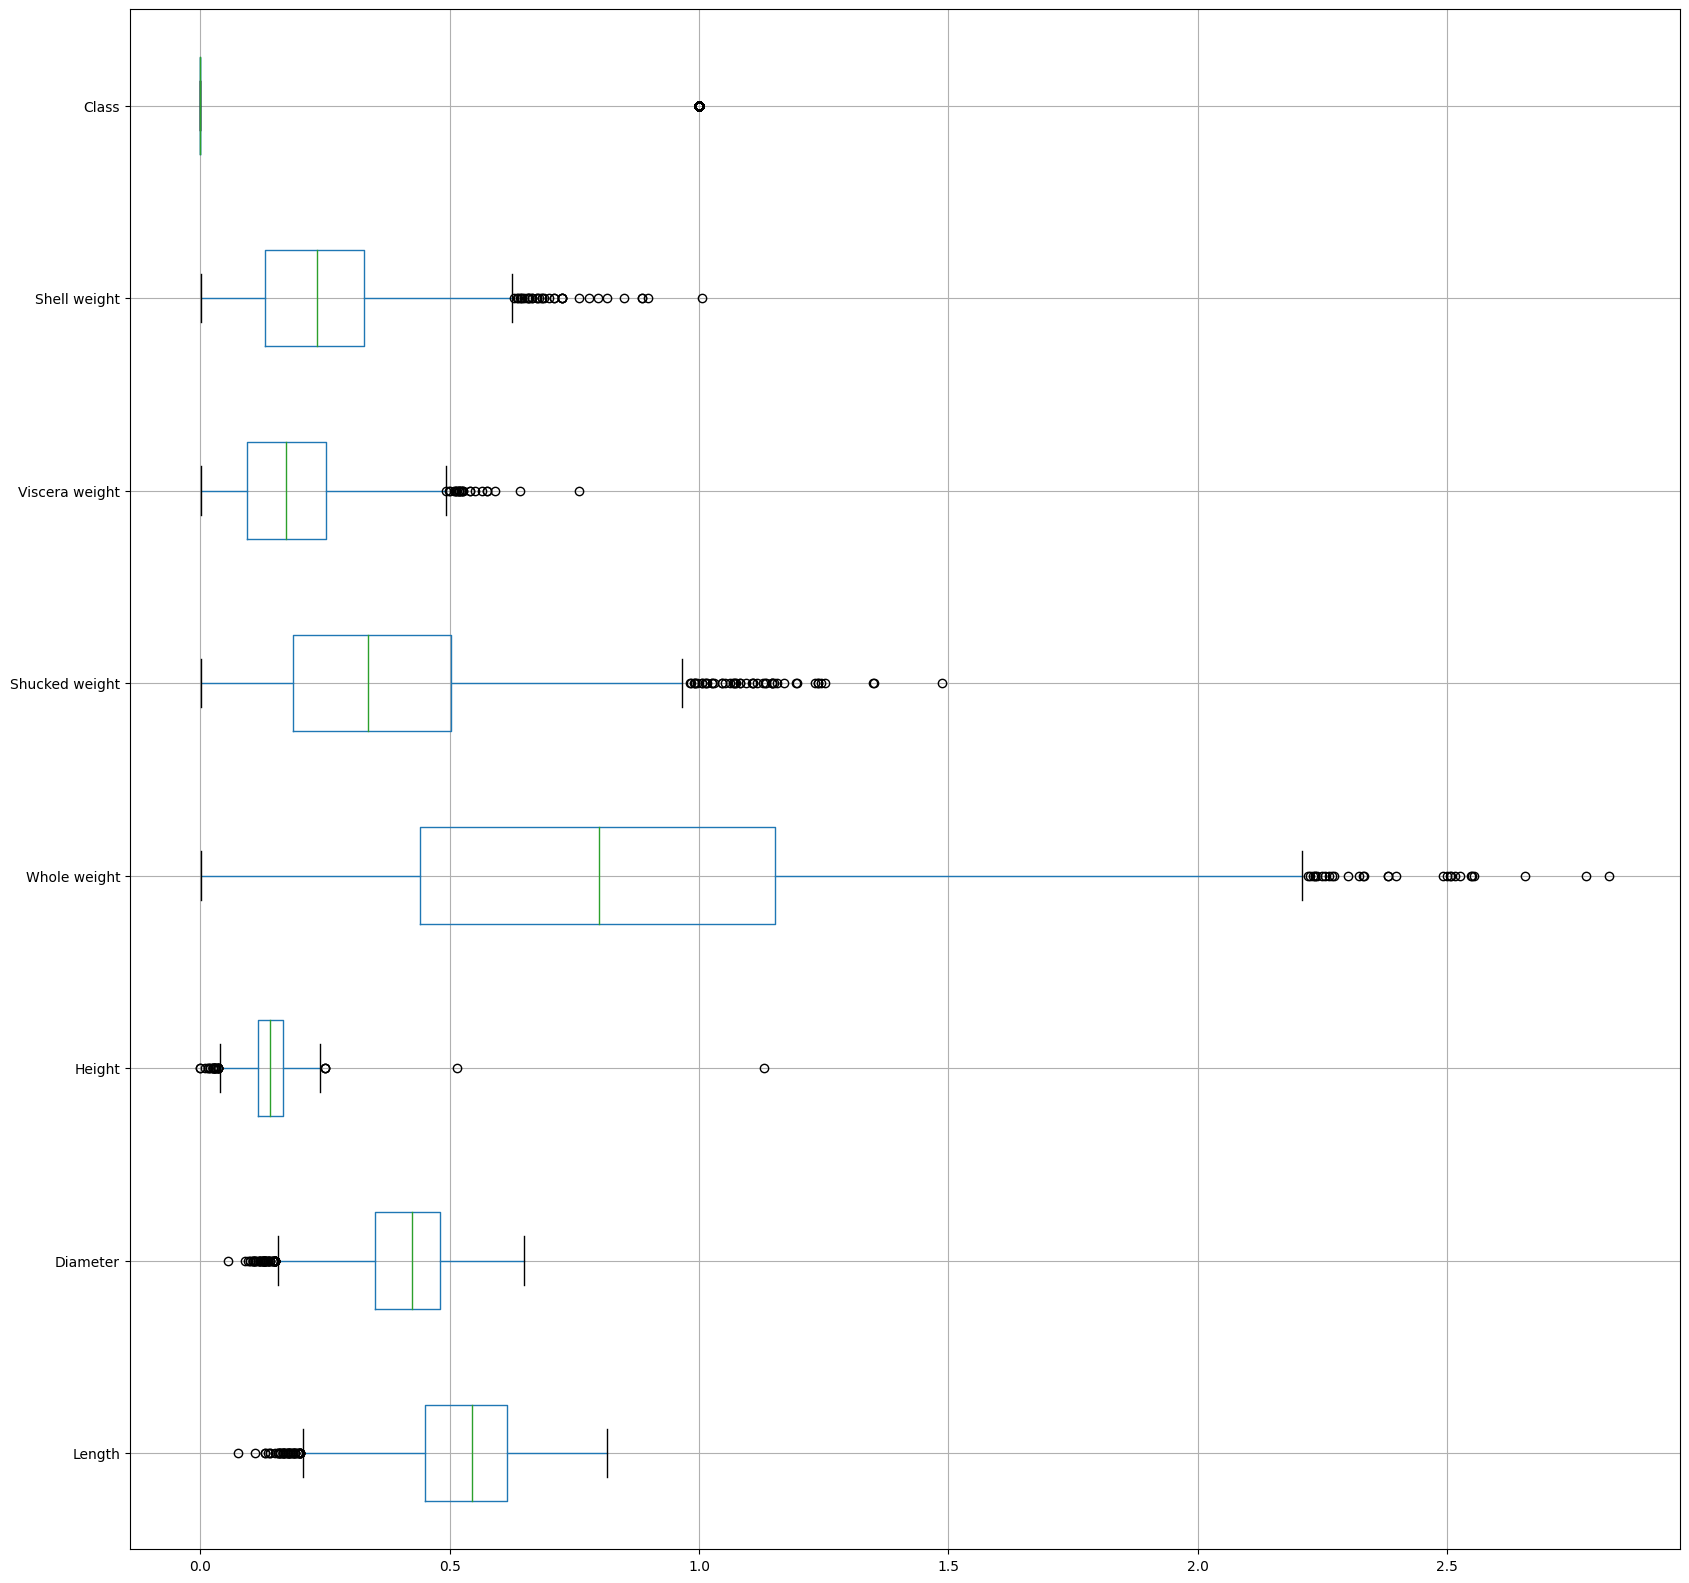

In [ ]:
# TODO: Lakukan preprocessing
df_reg = pd.read_csv("dataset.csv")

df_reg_numerical = df_reg.select_dtypes(include=['float64'])
df_reg_categorical = df_reg.select_dtypes(exclude=['float64'])

print('Ada', df_reg_numerical.shape[1], 'data numerikal')
print('Ada', df_reg_categorical.shape[1], 'data kategorikal')

col_numerical = list(df_reg_numerical.columns)
col_categorical = list(df_reg_categorical.columns)

print("Column Numerical: ", col_numerical)
print("Column Categorical: ", col_categorical)

preprocess(df_reg, "nah", "Whole weight", col_categorical)

### Split data

In [ ]:
# TODO: Lakukan split data menjadi train dan test
X_reg = df_reg[['Length', 'Height']]
y_reg = df_reg['Whole weight']

X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(X_reg, y_reg, test_size = 0.2, random_state = 2)
X_reg_train = pd.DataFrame(X_reg_train, columns=X_reg.columns)
X_reg_test = pd.DataFrame(X_reg_test, columns=X_reg.columns)
y_reg_train = pd.Series(y_reg_train, name="Whole weight")

X_reg_train_scaled, X_reg_test_scaled, temp_scaler = scale_train_and_test(X_reg_train, X_reg_test, ["Length", "Height"])
X_reg_train_scaled

,Length,Height
82,0.581560,0.320388
1161,0.709220,0.310680
3132,0.815603,0.330097
3672,0.687943,0.262136
68,0.517730,0.233010
...,...,...
3335,0.446809,0.262136
1099,0.553191,0.271845
2514,0.510638,0.213592
3606,0.567376,0.213592


### Train dan test model

In [ ]:
from sklearn import metrics

def evaluate_regression_performance(y_test, y_predict):
  print("MSE:", metrics.mean_squared_error(y_test, y_predict))
  print("MAE:", metrics.mean_absolute_error(y_test, y_predict))
  print("RMSE:", metrics.mean_squared_error(y_test, y_predict, squared=False))
  print("R-squared:", metrics.r2_score(y_test, y_predict))
  print("\n" + "#"*60 + "\n")

In [ ]:
# TODO: Lakukan training dan testing pada model KNN
reg.fit(X_reg_train_scaled.values, y_reg_train.values)
reg_prediction = reg.predict(X_reg_test_scaled.values)

evaluate_regression_performance(y_reg_test.values, reg_prediction)

MSE: 0.014899946423444976
MAE: 0.08070299043062201
RMSE: 0.12206533669901941
R-squared: 0.942715986243587

############################################################



### Hyperparameter tuning

In [ ]:
# TODO: Lakukan hyperparameter tuning pada model KNN
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from math import sqrt

k_values = [3, 5, 7, 9, 11, 15, 21, 31, 41, 51, 63]
r2s = []

for k in k_values:
  for metric in ["euclidean", "manhattan"]:
    reg = KNN(k = k, metric = metric, task = "regression")
    reg.fit(X_reg_train_scaled.values, y_reg_train.values)
    prediction = reg.predict(X_reg_test_scaled.values)

    r2 = metrics.r2_score(y_reg_test.values, prediction)
    print(f'k={k} and metric = {metric.upper()}, R Squared={r2}')

    r2s.append(r2)

k=3 and metric = EUCLIDEAN, R Squared=0.935525244620447
k=3 and metric = MANHATTAN, R Squared=0.9375123855868396
k=5 and metric = EUCLIDEAN, R Squared=0.942715986243587
k=5 and metric = MANHATTAN, R Squared=0.9427102187319993
k=7 and metric = EUCLIDEAN, R Squared=0.9444025446679634
k=7 and metric = MANHATTAN, R Squared=0.9455308313688713
k=9 and metric = EUCLIDEAN, R Squared=0.9441069259881395
k=9 and metric = MANHATTAN, R Squared=0.9467458715205638
k=11 and metric = EUCLIDEAN, R Squared=0.9421289896878814
k=11 and metric = MANHATTAN, R Squared=0.947515034825516
k=15 and metric = EUCLIDEAN, R Squared=0.9432302356184559
k=15 and metric = MANHATTAN, R Squared=0.9471182766396655
k=21 and metric = EUCLIDEAN, R Squared=0.9414361214368856
k=21 and metric = MANHATTAN, R Squared=0.9468005462693281
k=31 and metric = EUCLIDEAN, R Squared=0.9419784907837838
k=31 and metric = MANHATTAN, R Squared=0.9464183353371547
k=41 and metric = EUCLIDEAN, R Squared=0.9416555387793972
k=41 and metric = MANHATT

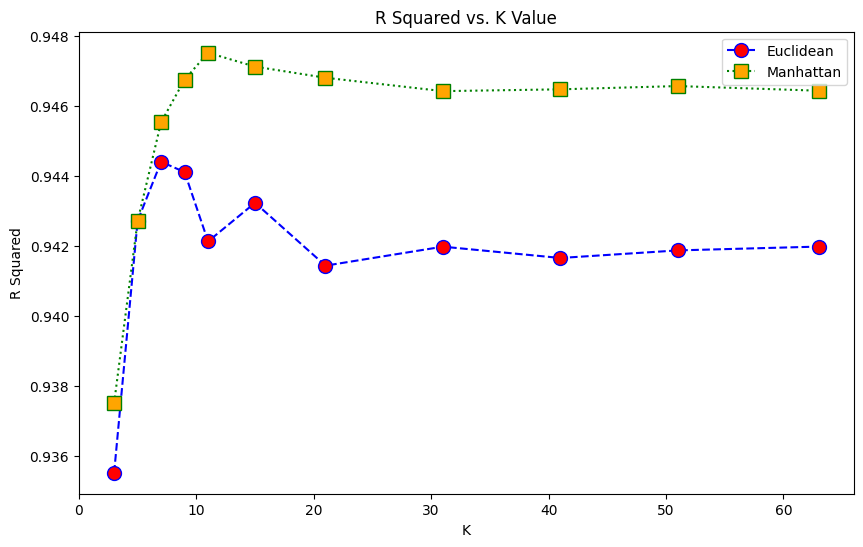

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(k_values, [(r2s[i]) for i in range(0, len(r2s), 2)] ,color='blue', linestyle='dashed',
         marker='o', markerfacecolor='red', markersize=10, label='Euclidean')

plt.plot(k_values, [(r2s[i]) for i in range(1, len(r2s), 2)], color='green', linestyle='dotted',
         marker='s', markerfacecolor='orange', markersize=10, label='Manhattan')

plt.title('R Squared vs. K Value')
plt.xlabel('K')
plt.ylabel('R Squared')
plt.legend()
plt.show()

# Pertanyaan

1. Apa saja pertimbangan yang harus diperhatikan dalam menentukan nilai k?

> Untuk menentukan nilai `k`, biasanya kita dapat melihat dari beberapa aspek seperti:
- Ukuran Dataset:
    - Jika dataset relatif kecil, menggunakan nilai `k` yang kecil dapat meningkatkan sensitivitas model terhadap variasi data.
    - Sedangkan itu, nilai `k` yang lebih besar mungkin lebih cocok untuk menghindari overfitting.
- Jumlah Kelas:
  - Jika jumlah kelas rendah, nilai `k` yang kecil mungkin lebih baik.
  - Jika jumlah kelas tinggi, nilai `k` yang lebih besar dapat membantu mengurangi noise dan fluktuasi yang mungkin terjadi.
Perlu diperhatikkan bahwa `k` yang lebih kecil membuat model lebih sensitif terhadap noise namun mungkin overfit, sedangkan `k` yang lebih besar memberikan prediksi yang lebih baik namun mungkin kehilangan detail (Curse of Dimensionality).
Pada kasus ini, saya mencoba-coba nilai k dengan menggunakan hyperparameter tuning, dimana saya menggunakan komputasi untuk mencari nilai k yang memberikan F1-Score yang baik. F1-Score merupakan teknik evaluasi performa yang seimbang sehingga cocok untuk digunakkan dalam kasus KNN ini. Step by step yang dilakukan untuk mendapatkan k yang optimal:
- Fit model KNN untuk nilai `k` yang berbeda
- Memprediksi dengan model KNN tersebut
- Evaluasi performa berdasarkan prediksi yang dihasilkan model
- Membandingkan hasil setiap model dan temukan model dengan error terendah, atau skor kedekatan tertinggi (F1 Score & R^2).


2. Untuk Classification dan Regression, bagaimana hasil percobaan antara menggunakan euclidean distance dan manhattan distance untuk nilai k yang sama? Apa yang menyebabkan hal tersebut terjadi?

> Untuk nilai k yang sama, berdasarkan percobaan yang saya lakukan, pada klasifikasi penggunaan metric euclidian distance secara keseluruhan memberikan hasil yang lebih baik dibandingkan manhattan distance. Hal ini disebabkan karena metric Manhattan menghitung jarak hanya secara vertikal atau horizontal karena memiliki batasan dimensi. Maka dari itu, metric euclidean lebih baik digunakan di dimensi yang lebih besar untuk menghitung jarak antar titik data.
<br> <br>
Di lain sisi, untuk kasus regression dimana fitur yang dipilih hanyalah 2, menyebabkan manhattan distance secara keseluruhan memberikan performa yang lebih baik dibandingkan menggunakan metric euclidean. Pada kasus ini perhitungan jarak dapat dilakukan secara vertikal maupun horizontal menyebabkan performa yang lebih baik.

3. Untuk Classification dan Regression, berdasarkan hasil hyperparameter tuning, apa rumus jarak dan nilai k yang paling optimal? Apa performance metrics yang Anda gunakan? Jelaskan dengan menyertakan alasannya

> Untuk classification, berdasarkan hasil hyperparameter tuning, saya mencari performa yang terbaik berdasarkan metric F1 Score. Penggunaan F1 dapat dilihat dari imbalanced pembagian dari kelas kerang yang ada. Berdasarkan bukti dibawah, dapat dilihat bahwa jumlah kelas 1 dari data hanyalah sekitar 1/4 kelas 0 kerang. Hal ini menunjukkan distribusi yang imbalanced sehingga F1 Score dapat digunakkan untuk mengevaluasi performa dari model kita. Berdasarkan hyperparameter tuning, saya mendapatkan nilai `k = 5` dan rumus jarak euclidean memberikan hasil yang optimal. Hal ini konsisten dengan deduksi (nomor 2) saya diatas.

In [ ]:
from collections import Counter

counter_y = Counter(y_clf)
print(counter_y)

Counter({0: 3217, 1: 960})


> Untuk regression, berdasarkan hasil hyperparameter tuning, saya mencari performa terbaik berdasarkan evaluasi metric `R^2`. Penggunaan evaluasi metric ini baik karena tidak adanya dataset test yang diberikan, sehingga kita hanya ingin melihat apakah model kita dapat memprediksi apakah model kita fit terhadap data test yang diberikan (*seen data*). Melalui percobaan, kita dapat melihat bahwa nilai `R^2` yang dihasilkan konsisten diatas 0.9, sehingga dapat dikatakan bahwa model kita cukup fit dalam memprediksi berat keseluruhan dari kerang abalone. Dari percobaan yang dilakukan, diperoleh bahwa `k = 11` dan rumus jarak manhattan memberikan nilai `R^2` yang terbaik.

4. Untuk Classification, apa variabel yang Anda pilih untuk memprediksi Class dari kerang Abalone? Jelaskan mengapa Anda memilih variabel tersebut

> Untuk klasifikasi Class dari kerang Abalone, saya memilih semua variabel independen kecuali "**Viscera weight**". Seleksi ini saya lakukan berdasarkan korelasi yang saya perlihatkan pada tahap preprocessing data. Dapat dilihat bahwa atribut `Length` dan `Viscera weight` memiliki korelasi yang sama terhadap atribut Class. Hal ini membuat saya memutuskan bahwa salah satu atribut cukup sebagai data untuk di train pada model kita. Hal ini juga didapatkan dari hasil percobaan saya sebelumnya dimana pada saat mengeliminasi lebih banyak fitur, menyebabkan performa model menurun. Oleh karena itu, karena menurut saya atribut `Viscera weight` dapat direpresentasikan oleh `Length` maka saya memutuskan untuk drop atribut tersebut.

5. Apa pertimbangan dalam memilih kNN dibandingkan dengan metode classification dan regression lainnya? Jelaskan juga pada saat kondisi apa metode classification dan regression dapat bekerja dengan lebih baik

> Dalam memilih metode klasifikasi dan regresi menggunakan kNN dapat dipantau melalui kondisi berikut:
- Data yang memiliki pola yang jelas dan keterhubungan yang baik:
  - Model kNN cocok untuk data yang memiliki pola yang jelas, di mana pola-pola keputusan berhubungan dengan tetangga terdekat, contohnya pada kasus Rumah dimana kita memprediksi harga rumah dari tanah, lokasi geografis, dll. Tentu saja, dari data tersebut, kNN dapat menjadi model yang baik karena data rumah memiliki "tetangga yang dekat" dan berkorelasi (apabila tanah lebih besar dan lokasi semakin geografis, maka semakin mahal, dll.).
- Data Tanpa Asumsi Distribusi Tertentu:
  - Model kNN juga efektif ketika distribusi data tidak diketahui.
- Ukuran Dataset yang Relatif Kecil:
  - model kNN cenderung lebih cocok untuk dataset yang relatif kecil karena memerlukan penyimpanan seluruh dataset dan perhitungan jarak untuk setiap prediksi.
- Dataset yang dengan fitur sedikit
  - Penambahan fitur, artinya membuat komputasi semakin meningkat. Dapat dilakukan feature selection untuk menghadapi situasi ini, namun dilain sisi, dapat menghilangkan berbagai unsur penting pada fitur yang dibuang.
- Data dengan Noise yang Dapat Diabaikan:
  - kNN dapat bekerja lebih baik dalam situasi di mana data mengandung noise yang dapat diabaikan atau dinormalisasi.

6. Apa yang Anda ketahui tentang weighted k-NN?

> Weighted k-NN adalah variasi dari algoritma k-NN yang memberikan bobot berbeda pada setiap tetangga terdekat. Bobot ini mencerminkan tingkat kontribusi relatif dari setiap tetangga terhadap prediksi. Beberapa tetangga mungkin memiliki pengaruh lebih besar daripada yang lain dalam proses melakukan prediksi. Tetangga yang memiliki pengaruh lebih besar, akan memiliki bobot yang lebih besar, begitu juga sebaliknya.
<br><br>
Berbeda dengan teknik kNN biasa, metode weighted k-NN tidak hanya mempertimbangkan tetangga terdekat, tetapi juga seberapa dekat atau jauh mereka berada. Dalam pendekatan ini, model akan memperlakukan semua tetangga terdekat sama, kita memberikan bobot yang berbeda kepada mereka berdasarkan jarak mereka dari fitur yang ingin diprediksi.

>Dalam mengklasifikasi, weighted k-NN berbeda dengan normal k-NN:
- Menetapkan bobot yang berbeda untuk masing-masing `k` tetangga berdasarkan jarak.
- Tetangga yang lebih dekat memiliki pengaruh yang lebih besar terhadap prediksi tersebut.
<br>
Perbedaan dapat dilihat dimana pada normal k-NN, biasa menggunakan modus untuk mengklasifikasikan suatu kelas. Hal tersebut karena semua `k` tetangga dianggap memiliki bobot yang sama.

> Dalam regresi, weighted k-NN juga berbeda dengan normal k-NN:
- Menetapkan bobot yang berbeda ke tetangga berdasarkan jarak.
- Tetangga yang lebih dekat memiliki dampak rata-rata yang lebih besar, sehingga mempengaruhi nilai prediksi secara lebih signifikan.

> Berbagai keuntungan yang diperoleh apabila menggunakan Weighted kNN:
- Peningkatan Akurasi: Dengan memperhitungkan jarak antar tetangga, metode k-NN tertimbang seringkali menghasilkan prediksi yang lebih akurat.
- Mengurangi Bias: Pendekatan ini mengurangi bias terhadap kelas mayoritas dalam dataset yang tidak seimbang dengan memberikan bobot lebih besar pada kelas minoritas.
-Fleksibel: Mampu menyesuaikan pembagian bobot sesuai kebutuhan.